## 1. 라이브러리 및 데이터
### Library & Data

In [2]:
import pandas as pd                         # 데이터 분석 라이브러리
import numpy as np                          # 계산 라이브러리
from tqdm import tqdm                       # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
from lightgbm import plot_importance
import matplotlib.pyplot as plt
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings
import joblib
warnings.filterwarnings("ignore")           # 경고 문구 미표시
model_name = 'lightgbm'
%matplotlib inline

In [58]:
# train_path = 'data/train.csv'
# test_path = 'data/test.csv'
model_path = 'model/'+model_name+'_model.pkl'

## 2. 데이터 전처리
### Data Cleansing & Pre-Processing

In [4]:
# 입력하세요.

## 3. 탐색적 자료분석
### Exploratory Data Analysis

In [5]:
# 입력하세요.

## 4. 변수 선택 및 모델 구축
### Feature Engineering & Initial Modeling

1) Feature로 각 플레이어의 종족, 게임 내 이벤트 발생 숫자, 플레이어간 이벤트 발생 숫자의 차이를 사용합니다.
1-1) 종족을 숫자로 변환 (T:0, P:1, Z:2)
1-2) 이벤트 발생 숫자는 8개 이벤트에 대해 각각 추출
1-3) 플레이어간 이벤트 발생 숫자를 Feature로 추가
1-4) 플레이어간 이벤트 발생 숫자 차이를 Feature로 추가

2) 모델로 LGBMClassifier를 사용합니다.

3) 훈련 세트를 5등분 하여 5-fold Cross Validation을 수행합니다.

4) Bayesian optimization을 사용하여 하이퍼 파라미터를 조정합니다.
4-1) 조정되는 하이퍼 파라미터: num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda
4-2) Score로 AUC를 사용하며 AUC가 가장 높도록 하이퍼 파라미터 조정

In [6]:
def species_converter(string):
    if string == 'T':
        return 0
    elif string == 'P':
        return 1
    elif string == 'Z':
        return 2
    else:
        raise ValueError

def data_preparation(df, answer=False):
    game_ids = df['game_id'].unique()
    events = ['Ability', 'AddToControlGroup', 'Camera', 'ControlGroup', 'GetControlGroup', 'Right Click', 'Selection', 'SetControlGroup']
    unique_event_0, unique_event_1, delta_event = {}, {}, {}
    for event in events:
        unique_event_0['P0_' + event] = 0
        unique_event_1['P1_' + event] = 0
        delta_event['delta_' + event] = 0
        
    species = df.groupby(['game_id', 'player']).species.unique()
    event_count = df.groupby(['game_id', 'player']).event.value_counts()
    if answer:
        winners = df.groupby(['game_id']).winner.max()
    
    x_data, y_data = [], []
    for game_id in tqdm(game_ids):
        df_event_count = event_count[game_id].unstack(level=-1)
        df = pd.DataFrame(species[game_id])
        df = pd.concat([df, df_event_count], axis=1)   
        df = df.fillna(0)
        
        df_P0_species = pd.DataFrame([species_converter(df.loc[0]['species'][0])], columns=['P0_species'])        
        df_P1_species = pd.DataFrame([species_converter(df.loc[1]['species'][0])], columns=['P1_species'])
        df = df.drop(['species'], axis=1)

        df_P0_event = unique_event_0.copy()
        for column in df.columns:
            df_P0_event['P0_' + column] = df.loc[0][column]
        df_P0_event = pd.DataFrame(pd.Series(df_P0_event)).T

        df_P1_event = unique_event_1.copy()
        for column in df.columns:
            df_P1_event['P1_' + column] = df.loc[1][column]
        df_P1_event = pd.DataFrame(pd.Series(df_P1_event)).T
        
        df_delta_event = delta_event.copy()
        for column in df.columns:
            df_delta_event['delta_' + column] = df_P0_event['P0_' + column][0] - df_P1_event['P1_' + column][0]
        df_delta_event = pd.DataFrame(pd.Series(df_delta_event)).T

        out = pd.concat([df_P0_species, df_P0_event, df_P1_species, df_P1_event, df_delta_event], axis=1)
        out.index = [game_id]
        out.index.name = 'game_id'
        
        x_data.append(out)
        if answer:
            y_data.append(winners[game_id])  

    x_data = pd.concat(x_data)
    y_data = np.array(y_data)
    
    return x_data, y_data

In [7]:
# train.csv 원본 파일 읽고 data_preparation 진행
# train = pd.read_csv('data/train.csv')
# x_train, y_train = data_preparation(train, answer=True)

# 전처리된 데이터 csv 파일로 저장
# x_train.to_csv('data/baseline_x_train.csv')
# np.savetxt("data/baseline_y_train.csv", y_train, delimiter=",")
# x_train.head()

In [54]:
# 전처리된 csv 파일 읽기
x_train = pd.read_csv('data/baseline_x_train.csv', index_col='game_id')
y_train = np.loadtxt('data/baseline_y_train.csv', delimiter=',', dtype=np.float32)

In [55]:
# important_features = [
#     'P1_Ability',
#     'P0_Ability',
#     'delta_Ability',
#     'P1_Camera',
#     'P0_Camera',
#     'delta_Camera',
#     'P1_GetControlGroup',
#     'P0_GetControlGroup',
#     'delta_GetControlGroup',
#     'P1_Selection',
#     'P0_Selection',
#     'delta_Selection',
#     'delta_Right Click',
#     'P1_Right Click',
#     'P0_Right Click']
# x_train = x_train[important_features]

In [56]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)[:, 1]
        true = y_valid
        score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [57]:
func_fixed = partial(lgb_cv, x_data=x_train, y_data=y_train, n_splits=5, output='score') 
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),
        'learning_rate': (0.0001, 0.1),
        'n_estimators': (16, 1024),
        'subsample': (0, 1),
        'colsample_bytree': (0, 1),
        'reg_alpha': (0, 10), 
        'reg_lambda': (0, 50),
    }, 
    random_state=4321
)
lgbBO.maximize(init_points=5, n_iter=30)

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6186   |  0.0708   |  0.08152  |  790.0    |  304.6    |  1.931    |  48.95    |  0.4062   |
|  2        |  0.646    |  0.7578   |  0.009006 |  328.4    |  639.9    |  4.599    |  10.92    |  0.6635   |
|  3        |  0.6258   |  0.6787   |  0.09504  |  299.5    |  640.8    |  3.833    |  20.02    |  0.9427   |
|  4        |  0.6216   |  0.9299   |  0.09484  |  394.5    |  361.0    |  6.648    |  2.116    |  0.2322   |
|  5        |  0.6434   |  0.4301   |  0.007886 |  788.7    |  876.7    |  1.504    |  5.057    |  0.2709   |
|  6        |  0.649    |  0.3634   |  0.01062  |  1.023e+0 |  44.64    |  7.323    |  0.824    |  0.7852   |
|  7        |  0.6353   |  0.7974   |  0.0001   |  16.0     |  1.024e+0 |  10.0     |  0.0      |  1.0      |
|  8      

## 5. 모델 학습 및 검증
### Model Tuning & Evaluation
1) AUC가 가장 높은 하이퍼 파라미터를 사용해 최종 모델을 얻습니다.

2) 훈련 세트와 같은 방법으로 테스트 세트에서 Feature를 추출합니다.

3) 최종 모델을 사용해 예측을 수행합니다.

4) 예측 결과를 submission.csv로 저장합니다.

In [11]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=x_train, y_data=y_train, n_splits=5, output='model')
joblib.dump(models, model_path)

['model/lightgbm_model.pkl']

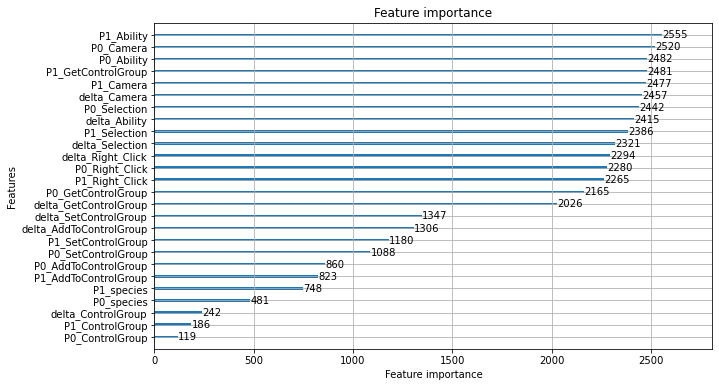

In [12]:
_, ax = plt.subplots(figsize=(10, 6))
plot_importance(models[0], ax=ax)

In [13]:
# test.csv 원본 파일 읽고 data_preparation 진행
# test = pd.read_csv('data/test.csv')
# x_test, _ = data_preparation(test, answer=False)

# 전처리된 데이터 csv 파일로 저장
# x_test.to_csv('data/baseline_x_test.csv')
# x_test.head()

In [13]:
# 전처리된 csv 파일 읽기
x_test = pd.read_csv('data/baseline_x_test.csv', index_col='game_id')

In [14]:
models = joblib.load(model_path)
preds = []
for model in models:
    pred = model.predict_proba(x_test)[:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

submission = pd.read_csv('data/sample_submission.csv', index_col=0)
submission['winner'] = submission['winner'] + pred
submission.to_csv('submission.csv')
submission.head()

,winner
game_id,
38872,0.624099
38873,0.507633
38874,0.449902
38875,0.287078
38876,0.450226


## 6. 결과 및 결언
### Conclusion & Discussion

In [ ]:
# 입력하세요.